In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

from scipy.optimize import curve_fit

from qick import *

from qick_training import *

In [2]:
soc = QickTrainingSoc(bitfile="/data/QCE2023/demos_qce/firmware/qick_training.bit")

soccfg = soc
print(soccfg)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.268
	Firmware timestamp: Wed Sep  6 15:36:36 2023

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 32-b

In [230]:
simu = SimuChain(soc,soc['simu'][0], name="226_2 <-> 229_0")
###############################
### Resonator Configuration ###
###############################
simu.qout(3)
simu.analysis.qout(3)
simu.synthesis.qout(1)

# Disable all resonators.
simu.alloff()

cfg = {'sel':'resonator', 'nstep':1}
# rest frequency of the resonator
cfg['freq'] = 600.0
# when triggered, the resonator freq will drop by this amount
cfg['sweep_freq'] = 2.0
# the resonator will jump back to its rest state after this amount of time
cfg['sweep_time'] = 5.0

# IIR filter parameters - see later
cfg['iir_c0'] = 0.99
cfg['iir_c1'] = 0.8

simu.set_resonator(cfg, verbose=True)

SimuChain: f = 600.0 MHz, fd = -14.399999999999977 MHz, k = 253, fdds = 2.1316282072803006e-14 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 253
AxisKidsimV3: lane       = 5
AxisKidsimV3: punct_id   = 31
AxisKidsimV3: iir_c0     = 0.99
AxisKidsimV3: iir_c1     = 0.8
AxisKidsimV3: iir_g      = 0.9045226130653267
AxisKidsimV3: dds_freq   = 2.1316282072803006e-14
AxisKidsimV3: dds_wait   = 47
AxisKidsimV3: sweep_freq = 2.0
AxisKidsimV3: sweep_time = 5.0
AxisKidsimV3: nstep      = 1
freq = 0, bval = 13653, slope = 13653, steps = 1, wait = 47
c0 = 32440, c1 = 26214, g = 29639
sel = 0, punct_id = 31, addr = 5


  0%|          | 0/1 [00:00<?, ?it/s]

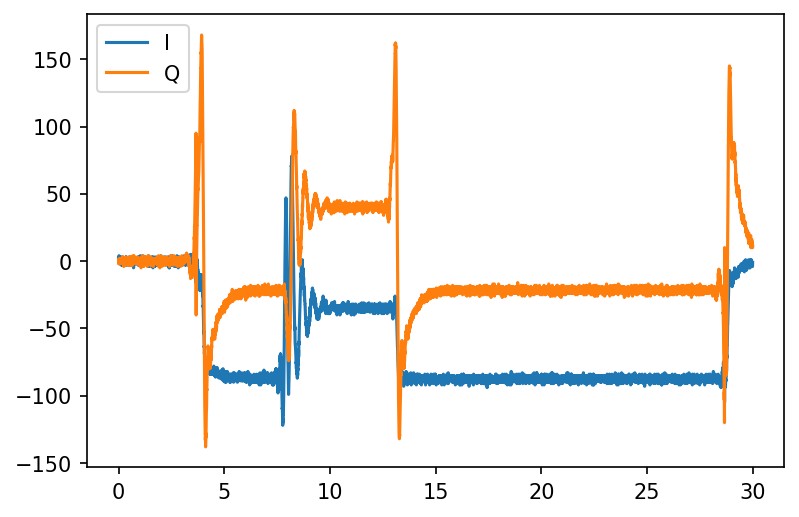

In [128]:
class ResonatorJump(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1)
                        
        # First channel.
        length   = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch'])
        freq_gen = self.freq2reg(self.cfg['pulse_freq'], gen_ch=self.cfg['gen_ch'], ro_ch=self.cfg['ro_ch'])
        self.set_pulse_registers(ch     = self.cfg['gen_ch'],
                                     style  = 'const',
                                     length = length,
                                     freq   = freq_gen,
                                     phase  = 0,
                                     gain   = self.cfg['pulse_gain'])
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch']),
                             freq    = self.cfg['pulse_freq'],
                             gen_ch  = self.cfg['gen_ch'])        
        
        self.synci(200)  # give processor some time to configure pulses      
    
    def body(self):
        # Trigger.
        self.trigger(adcs=self.ro_chs, pins=[0],adc_trig_offset=0)

        # Pulse.
        self.pulse(ch = self.cfg['gen_ch'], t=0)
        
        # Resonator Jump.
        if self.cfg['do_jump']:
            self.trigger(pins=list(range(4,12)),t=self.us2cycles(self.cfg['trigger_off']))
        
config={"gen_ch"      : 4,
        "reps"        : 1,
        "soft_avgs"   : 1,
        "pulse_length": 25,
        "pulse_gain"  : 8000, # [DAC units]
        "pulse_freq"  : 600, # [MHz]
        "trigger_off" : 5,
        "ro_ch"     : 4,
        "ro_length" : 30,
        'do_jump' : True
       }

prog = ResonatorJump(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)
plt.figure(dpi=150)

# Time index.
iq = iq_list[0]
t = prog.get_time_axis(ro_index=0)
plt.plot(t, iq[0], label='I')
plt.plot(t, iq[1], label='Q')
plt.legend();

  0%|          | 0/500 [00:00<?, ?it/s]

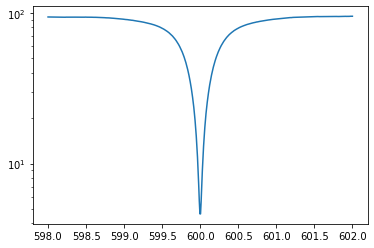

In [231]:
config={"gen_ch"      : 4,
        "reps"        : 1,
        "soft_avgs"   : 1,
        "pulse_length": 25,
        "pulse_gain"  : 8000, # [DAC units]
        "pulse_freq"  : 600, # [MHz]
        "trigger_off" : 5,
        "ro_ch"     : 4,
        "ro_length" : 30,
        'do_jump' : False
       }

freqs = np.linspace(598, 602, 500)
iqs = []
for f in tqdm(freqs):
    config['pulse_freq'] = f
    prog = ResonatorJump(soccfg, config)
    iq = prog.acquire(soc, progress=False)
    iqs.append(iq[0][0][0]+1j*iq[1][0][0])
iqs = np.array(iqs)

plt.semilogy(freqs, np.abs(iqs))

FWHM estimate: 600.0040080160321 -26.243262273009766 0.1523046092183904
Lorentzian fit: [ 1.11398139e-01  5.99999980e+02 -7.63741226e+00]


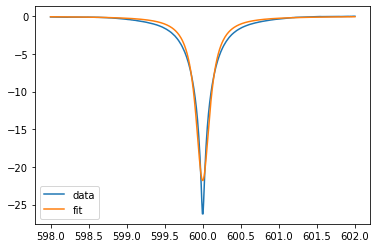

In [241]:
# fit a lorentzian to the power

def lorentzian(f, gamma, f0, A):
    return (A/np.pi) / (gamma) / (1 + np.power((f-f0)/(gamma),2.))

def FWHM_analytic(f, S21):
    f_min = f[np.argmin(S21)] #; print(f_min)
    S_min = np.min(S21) #; print(S_min)
    halfmax = S_min/2 #; print(halfmax)
    hm_f_lo = f[f<f_min][np.argmin(np.abs(S21[f<f_min]-halfmax))] #; print(hm_f_lo)
    hm_f_hi = f[f>f_min][np.argmin(np.abs(S21[f>f_min]-halfmax))] #; print(hm_f_hi)
    FWHM = hm_f_hi - hm_f_lo
    return f_min, S_min, FWHM

dbs = 20*np.log10(np.abs(iqs))
dbs -= np.max(dbs)
plt.plot(freqs, dbs, label='data')

f_min , S_min, FWHM = FWHM_analytic(freqs, dbs)
guess = [FWHM , f_min , -30]
gss_lorentzian = lorentzian(freqs, *guess)
popt, pcov = curve_fit(lorentzian, freqs, dbs, maxfev = 100000, p0 = guess)
fit_lorentzian = lorentzian(freqs, *popt)

plt.plot(freqs, fit_lorentzian, label='fit')
plt.legend()
# plt.xlim([popt[1]-5*popt[0], popt[1]+5*popt[0]])
print("FWHM estimate:", f_min , S_min, FWHM)
print("Lorentzian fit:", popt)

pole-zero fit: [599.99967701   0.9834057    0.7095722   95.19705136]


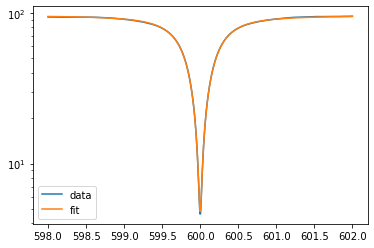

In [242]:
# fit a pole-zero function to the magnitude
# gives a good fit, though we clearly don't know how to normalize the parameters correctly

def polezero(f, f0, c0, c1, G):
    z = np.exp(1j*f)
    # leo applies an overall G0 = (1+c1)/(1+c0) which seems to normalize to 1 far from the resonance
    G0 = (1+c1)/(1+c0)
    return G*G0*np.abs((z-c0*np.exp(1j*f0))/(z-c1*np.exp(1j*f0)))


mags = np.abs(iqs)
plt.semilogy(freqs, mags, label='data')

guess = [f_min, 0.99, 0.8, np.max(mags)]
popt, pcov = curve_fit(polezero, freqs, mags, maxfev = 100000, p0 = guess)
fit_polezero = polezero(freqs, *popt)
plt.semilogy(freqs, fit_polezero, label='fit')
plt.legend()

print("pole-zero fit:", popt)

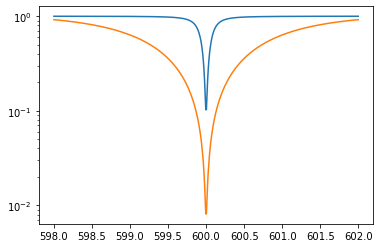

In [260]:
# vary c1 - this seems to set the width scale
plt.semilogy(freqs, polezero(freqs, 600, 0.99, 0.9, 1.0))
plt.semilogy(freqs, polezero(freqs, 600, 0.99, 0.2, 1.0))

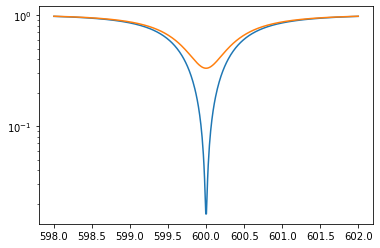

In [259]:
# vary c0 - this seems to set the depth of the minimum
plt.semilogy(freqs, polezero(freqs, 600, 0.99, 0.5, 1.0))
plt.semilogy(freqs, polezero(freqs, 600, 0.8, 0.5, 1.0))